![ThinkOnward Logo](assets/ThinkOnward.png)
# The Geophysical Foundation Model
#### Jesse Pisel and Jeff Roth, November 2024

Make sure you install the required packages from `requirements.txt` as outlined in the `README` file in the repository root directory.

First you need to import packages needed for data wrangling and inference. You also need to add the current path to the system path so you can import the GFM architecture later on.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as st
import torch
import os
import sys

In [2]:
# add the geophysical-foundation-model directory to system path for later
current_dir = os.path.abspath(os.path.dirname('..'))
project_root = os.path.dirname(current_dir)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

To download the data and the model you will need a [HuggingFace](https://huggingface.co) account and [request model access](https://huggingface.co/thinkonward/geophysical-foundation-model)

<img src="assets/model_card.png" alt="huggingface model card" width="800"/>


After requesting access, you need to [set up an access token](https://huggingface.co/docs/hub/security-tokens) to use the `huggingface_hub` package. Once that is set up, log in by running the next cell and entering your token

In [3]:
from huggingface_hub import login, hf_hub_download, snapshot_download
login()

In [4]:
DATA_REPO_ID = "thinkonward/patch-the-planet"
DATA_FILENAME = "data/seismicCubes_RFC_fullstack_2023_66442858.parquet"

hf_hub_download(
    repo_id=DATA_REPO_ID,
    filename=DATA_FILENAME,
    repo_type="dataset",
    local_dir="./dataset",
)

(…)ubes_RFC_fullstack_2023_66442858.parquet:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

'dataset/data/seismicCubes_RFC_fullstack_2023_66442858.parquet'

## Data preprocessing
Define some functions to convert the seismic volume from parquet to numpy array and mask out a portion we want to interpolate

In [5]:
def parquet2array(parquet_file, original_shape=(300, 300, 1259)):
    df = pd.read_parquet(parquet_file)
    data_only = df.drop(columns=["Row", "Col"])
    # Convert the DataFrame back to a 2D numpy array
    reshaped_array = data_only.values
    # Reshape the 2D array back into a 3D array
    array = reshaped_array.reshape(original_shape)
    return array


def mask_image(seismic_slice):
    masked_file = seismic_slice.copy()
    # the masked chunk is hard coded here
    masked_file[:, 40:110] = 122
    mask = np.where(masked_file == 122.0, 1, 0)
    return masked_file, mask

Visualize the selected line from the volume and see what the model is going to interpolate and the mask

Text(0.5, 1.0, 'Mask')

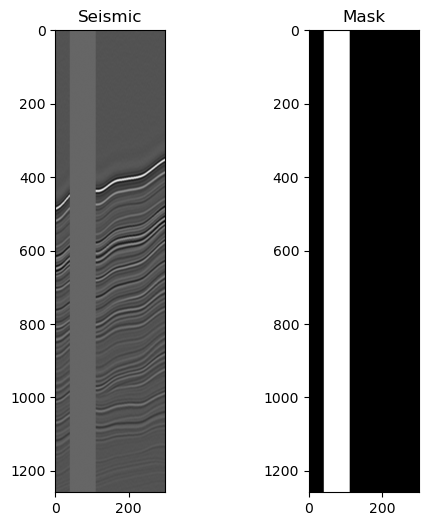

In [6]:
SEIS_VOL = parquet2array(
    "./dataset/data/seismicCubes_RFC_fullstack_2023_66442858.parquet"
)
SEISMIC_SLICE = SEIS_VOL.T[:, :, 10]
MASKED_SLICE, MASK = mask_image(SEISMIC_SLICE)

fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].imshow(MASKED_SLICE, cmap="gray")
ax[0].set_title("Seismic")
ax[1].imshow(MASK, cmap="gray")
ax[1].set_title("Mask")

## Instantiate the model
Create an instance of the model architecture, then load the downloaded weights using the `from_pretrained` method

In [7]:
from GFM import ElasticViTMAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ElasticViTMAE.ElasticViTMAE.from_pretrained("thinkonward/geophysical-foundation-model")
model = model.float()
model.to(device)

ElasticViTMAE(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 1200, kernel_size=(400, 1), stride=(400, 1))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-15): 16 x Block(
      (norm1): LayerNorm((1200,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1200, out_features=3600, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1200, out_features=1200, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1200,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1200, out_features=4800, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=4800, out_features=1200, bias=True)
        (drop

## Do some interpolation
Now the fun part
1. resize the seismic slice and mask to the shape for the model to ingest
2. get the number of visible patches
3. run inference
4. combine the prediction and visible portions
5. visualize it!

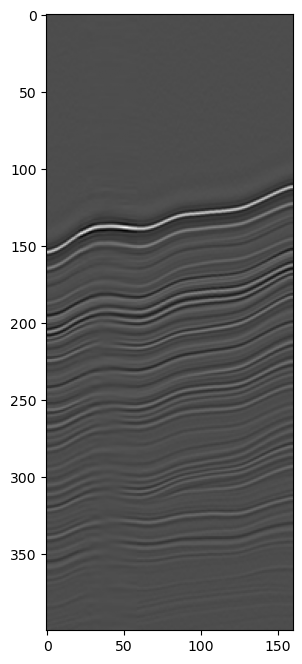

In [8]:
# Prepare seismic slice (seismic_slice: 2D slice of volume)
resized_slice = st.resize(
    MASKED_SLICE.T,
    model.patch_embed.img_size[::-1],
    order=3,
    anti_aliasing=True,
    preserve_range=True,
)
resized_slice = resized_slice.T.astype(np.float32)
resized_slice = (resized_slice - SEIS_VOL.mean()) / SEIS_VOL.std()
x = torch.tensor(resized_slice)
x = x.unsqueeze(0)  # add channel dim
x = x.unsqueeze(0)  # add batch dim
x = x.float()
x = x.to(device)

# Prepare mask (target_mask_slice: 2D slice of mask)
resized_mask = st.resize(
    MASK, model.patch_embed.img_size, order=0, preserve_range=True
)
mask_idx = np.flatnonzero(resized_mask[0, :])
input_mask = np.zeros(model.patch_embed.grid_size)
input_mask[:, mask_idx[0] : mask_idx[-1] + 1] = 1
input_mask = torch.tensor(input_mask)
input_mask = input_mask.float()
input_mask = input_mask.to(device)

# Prepare length of visible patches
len_keep = torch.tensor(int(input_mask.shape[1] - input_mask.sum()))
len_keep = len_keep.to(device)

# Get interpolated slice
loss, pred, mask = model(x, input_mask, len_keep)

# Combine prediction and visible part to generate output
mask = mask.unsqueeze(-1)
visible = model.patchify(x)
combined_pred = pred * mask + visible * (1 - mask)
combined_pred = model.unpatchify(combined_pred)
combined_pred = combined_pred.cpu().detach().numpy()
combined_pred = combined_pred.reshape(model.patch_embed.img_size)
combined_pred = combined_pred * SEIS_VOL.std() + SEIS_VOL.mean()

plt.figure(figsize=(8, 8))

plt.imshow(combined_pred, cmap="gray")